In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-10-08 11:46:02.953647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 11:46:02.953975: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 11:46:02.955777: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 11:46:02.961380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 11:46:02.970594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
def read_csv_to_df(path):
    return pd.read_csv(path)

f_range = (10,950)

h_data_path = f"s_data/healthy_f_{f_range[0]}_{f_range[1]}.csv"
p_data_path = f"s_data/pathology_f_{f_range[0]}_{f_range[1]}.csv"

h_df = read_csv_to_df(h_data_path)
p_df = read_csv_to_df(p_data_path)

h_data = []
p_data = []

for spectrogram_id, group in h_df.groupby('spectrogram_id'):
    # Extract frequency, time, and power values
    power = []
    for f, g in group.groupby("frequency"):
        p = g['power']
        p_num = p.to_numpy()
        power.append(p_num)
    p_ = np.array(power)
    p_shaped = p_.reshape(p_.shape[0], p_.shape[1], 1)  # Shape will be (129, 41, 1)
    h_data.append(p_shaped)

for spectrogram_id, group in p_df.groupby('spectrogram_id'):
    # Extract frequency, time, and power values
    power = []
    for f, g in group.groupby("frequency"):
        p = g['power']
        p_num = p.to_numpy()
        power.append(p_num)
    p_ = np.array(power)
    p_shaped = p_.reshape(p_.shape[0], p_.shape[1], 1)  # Shape will be (129, 41, 1)
    p_data.append(p_shaped)

In [3]:
# Stack the arrays for class 1 and class 0
X_class_1 = np.stack(h_data)  # Shape will be (n_samples_1, 129, 41, 1)
X_class_0 = np.stack(p_data)  # Shape will be (n_samples_0, 129, 41, 1)

# Print shapes to verify
print("Shape of X_class_1:", X_class_1.shape)  # Should show (n_samples_1, 129, 41, 1)
print("Shape of X_class_0:", X_class_0.shape)  # Should show (n_samples_0, 129, 41, 1)

# Concatenate the stacked arrays
X = np.concatenate((X_class_0, X_class_1), axis=0)  # Shape will be (total_samples, 129, 41, 1)
print("Shape of X:", X.shape) 

y_class_0 = np.zeros(X_class_0.shape[0])  # Labels for class 0
y_class_1 = np.ones(X_class_1.shape[0])   # Labels for class 1
y = np.concatenate((y_class_0, y_class_1))  # Combine labels
print(y.shape)

Shape of X_class_1: (51, 257, 33, 1)
Shape of X_class_0: (38, 257, 33, 1)
Shape of X: (89, 257, 33, 1)
(89,)


In [4]:
# train and test data?
from sklearn.model_selection import train_test_split

# Assuming X is your feature data and y is your label data

# Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True,  random_state=42)

# Check the shapes of the splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (44, 257, 33, 1)
X_test shape: (45, 257, 33, 1)
y_train shape: (44,)
y_test shape: (45,)


In [5]:
# Shuffle the dataset - this is done by the .fit method potentially?
#indices = np.arange(X.shape[0])  # Create an array of indices
#np.random.shuffle(indices)  # Shuffle indices
#X = X[indices]  # Shuffle the data
#y = y[indices]  # Shuffle the labels

y_train = np.array(y_train, dtype=np.int32)  # Convert labels to int32
y_test = np.array(y_test, dtype=np.int32)  # Convert labels to int32

# verify shapes of data and types
print("Shape of X Train:", X_train.shape)  # Should be (total_samples, 129, 41, 1)
print("Shape of X Test:", X_test.shape)  # Should be (total_samples, 129, 41, 1)
print("Shape of y Train:", y_train.shape)  # Should be (total_samples,)
print("Shape of y Test:", y_test.shape)  # Should be (total_samples,)
print("Type of X Train:", type(X_train))  # Should be <class 'numpy.ndarray'>
print("Type of X Test:", type(X_test))  # Should be <class 'numpy.ndarray'>
print("y dtype:", y_train.dtype)  # Should show int32
print("y dtype:", y_test.dtype)  # Should show int32

Shape of X Train: (44, 257, 33, 1)
Shape of X Test: (45, 257, 33, 1)
Shape of y Train: (44,)
Shape of y Test: (45,)
Type of X Train: <class 'numpy.ndarray'>
Type of X Test: <class 'numpy.ndarray'>
y dtype: int32
y dtype: int32


#### Define the CNN Model

In [6]:
# try sigmoid and softmax

#### last results (restart kernal first) ##################
# validation data of 0.1, batch_size 32
# 107ms/step - accuracy: 0.9607 - loss: 0.0576  
# Loss: 0.11523419618606567, Accuracy: 0.9213483333587646
###########################################################

#### last results (restart kernal first) ##################
# validation data of 0.3, batch_size 32
# 105ms/step - accuracy: 0.5795 - loss: 0.6805
# Loss: 0.6825977563858032, Accuracy: 0.5730336904525757
###########################################################

def generate_model(activation):
    a = (0,"")
    if(activation == "softmax"):
        a = (2, activation)
    elif(activation == "sigmoid"):
        a=(1, activation)
    print(a[1])
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', ), # no input_shape=(129,41,1)
        MaxPooling2D(pool_size=2, strides=1),

        Conv2D(64, (3, 3), activation='relu', ), # no input_shape=(129,41,1)
        MaxPooling2D(pool_size=2, strides=1),

        Conv2D(128, (3, 3), activation='relu', ), # no input_shape=(129,41,1)
        MaxPooling2D(pool_size=2, strides=1),

        Flatten(),
        Dense(256, activation='relu'),
        Dense(a[0], activation=a[1])
    
    ])

    return model

activation = "softmax"
model = generate_model(activation)
print(model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



softmax
<Sequential name=sequential, built=False>


#### Train the model

In [7]:
# Train the model
if(activation == "softmax"):
    y_train = to_categorical(y_train, num_classes=2)  # Convert to one-hot encoding
    y_test = to_categorical(y_test, num_classes=2)  # Convert to one-hot encoding

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6463 - loss: 8.5150 - val_accuracy: 0.6667 - val_loss: 35.5597
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6115 - loss: 3.7861 - val_accuracy: 0.6444 - val_loss: 9.1644
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7188 - loss: 0.5970 - val_accuracy: 0.4889 - val_loss: 6.8499
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8267 - loss: 0.3204 - val_accuracy: 0.6667 - val_loss: 12.5714
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9389 - loss: 0.2525 - val_accuracy: 0.5111 - val_loss: 17.5093
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9652 - loss: 0.2242 - val_accuracy: 0.6444 - val_loss: 19.8066
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9808 - loss: 0.1305 - val_accuracy: 0.5111 - val_loss: 22.3045
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9425 - loss: 0.1079 - val_accuracy: 0.5556 - val_loss: 25.6454
Epoch 9/50

#### Evaluate Model

In [9]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

from sklearn.metrics import confusion_matrix

2/2 - 0s - 132ms/step - accuracy: 0.5333 - loss: 66.3946
0.5333333611488342


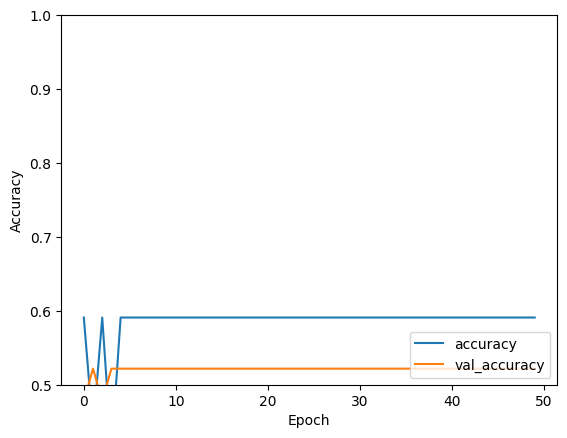

In [9]:
# plot the results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
